<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture06/notebooks/L06_Autoencoder_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Archivos colab/Lecture06'

/content/drive/MyDrive/Archivos colab/Lecture06


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

try:
    from plotting import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset
from tensorflow.keras import layers, Model, optimizers, losses
from tensorflow.keras.callbacks import Callback

In [ ]:
%load_ext autoreload
%autoreload 2

# Aprendizaje No Supervisado

## Etiquetar Datos es Costoso

En el aprendizaje automático supervisado, el objetivo es aprender un mapeo $f_{\psi} : \mathbf{x} \in \mathcal{R}^P \rightarrow \mathbf{y}$ de observaciones $\mathbf{x}$ al objetivo $\mathbf{y}$ utilizando un conjunto de datos $\mathcal{D} = \{\mathbf{x}_i, \mathbf{y}_i\}_{i=1, \dots, N}$ de tamaño finito N (por ejemplo, clasificación de imágenes, traducción). Debido a la maldición de la dimensionalidad, las entradas de alta dimensión (imágenes) y los modelos complejos (aprendizaje profundo) requieren grandes conjuntos de datos (millones de pares $(\mathbf{x}, \mathbf{y})$). En la práctica, etiquetar datos es costoso (por ejemplo, marcar la presencia de cáncer en escaneos de rayos X).

## La Compresión es Comprensión: Aprendizaje sin Objetivo

Para superar la maldición de la dimensionalidad, nuestro objetivo es aprender una representación comprimida $\mathbf{z} \in \mathcal{R}^M$ de $\mathbf{x}$ tal que $M < P$ y exista un mapeo $g_{\phi}: \mathbf{x} \rightarrow \mathbf{z}$ que vincule cada punto de datos con su representación. Idealmente, $\mathbf{z}$ es un conjunto de características de baja dimensión que describe eficientemente a $\mathbf{x}$. Como ilustración, al modelar imágenes de celebridades (conjunto de datos CelebA), el conjunto de características faciales (color de ojos, edad, longitud del cabello, etc.) es una representación comprimida (y con pérdida) de $\mathbf{x}$. En la práctica, la representación $\mathbf{z}$ no es observable y [es poco probable que coincida con dichas características conocidas](https://arxiv.org/abs/1811.12359). Sin embargo, la representación $\mathbf{z}$ es de baja dimensión y aprender un mapeo $f_{\psi} : \mathbf{z} \in \mathcal{R}^M \rightarrow \mathbf{y}$ suele ser más fácil.

Mientras que etiquetar los datos es costoso, las observaciones $\mathbf{x}$ son baratas de adquirir. En muchos casos, se puede rastrear la web para recopilar una gran colección de imágenes o textos. Como resultado, se pueden desplegar grandes modelos de aprendizaje profundo para aprender $g_{\phi}$, y modelos más pequeños/eficientes en datos pueden aplicarse posteriormente para resolver la tarea supervisada.

# Autoencoders: Compresión como Proceso de Generación

En este cuaderno, implementarás un autoencoder (AE) simple. Suponemos que ya estás familiarizado con los conceptos básicos de las redes neuronales. Comenzaremos definiendo un AE similar al utilizado en la etapa de ajuste fino por [Geoffrey Hinton y Ruslan Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf). Experimentaremos con la configuración del AE e intentaremos ejecutarlo en el conjunto de datos MNIST. Ha habido una gran variedad de investigaciones en el campo de los autoencoders y la técnica que estás a punto de aprender es muy simple en comparación con los métodos modernos: Autoencoders enmascarados ([MADE](https://arxiv.org/abs/1502.03509), [BERT](https://arxiv.org/abs/1810.04805)) y Autoencoders Variacionales ([VAE](https://arxiv.org/abs/1312.6114), [VQ-VAE](https://arxiv.org/abs/1711.00937), [BIVA](https://arxiv.org/abs/1902.02102), [NVAE](https://arxiv.org/abs/2007.03898)).

En el aprendizaje no supervisado, nuestro objetivo es aprender representaciones comprimidas $\mathbf{z} \in \mathcal{P}$ de $\mathbf{x} \in \mathcal{R}$ donde $M < P$. La arquitectura de un autoencoder puede descomponerse en dos pasos:

1. *Codificación* de $\mathbf{x}$ en una representación de baja dimensión $\mathbf{z}$ usando una red neuronal $g_{\phi} : \mathbf{x} \rightarrow \mathbf{z}$.
2. *Decodificación* de la representación $\mathbf{z}$ en una reconstrucción $\hat{\mathbf{x}} = h_\theta(\mathbf{z}) \in \mathcal{R}^P$.

Dado que $M < P$, la codificación actúa como un cuello de botella de información: solo una parte de la información que describe $\mathbf{x}$ puede ser codificada en $\mathbf{z}$ siempre que $M$ sea lo suficientemente pequeño.

El aprendizaje de los parámetros del autoencoder depende de dos aspectos:

1. Una distancia en el espacio de observación $d : \mathcal{R}^{P} \times \mathcal{R}^{P} \rightarrow \mathcal{R}$ (por ejemplo, MSE), que mide la calidad de la reconstrucción.
2. Uso de retropropagación junto con descenso de gradiente estocástico (SGD) para optimizar los parámetros $\{\phi, \theta\}$ con respecto a $L := \frac{1}{N} \sum_i d(x_i, h_{\theta}(g_{\phi}(\mathbf{x})))$.

![Autoencoder](https://drive.google.com/uc?export=view&id=1PbaP-ROV8fkT8KeJ4v7dEcl5-4u8SLWO)

*Los ejercicios se encuentran al final del cuaderno.*


## MNIST

Primero, carguemos el conjunto de datos MNIST y dibujemos algunos ejemplos. En este cuaderno, utilizaremos los *dataloaders* y *datasets* proporcionados por PyTorch. Definir la carga de conjuntos de datos utilizando un *dataloader* tiene la ventaja de que solo carga los datos que son *necesarios* en la memoria, lo que nos permite utilizar conjuntos de datos a gran escala.

Cargaremos solo una cantidad limitada de clases definidas por la variable `classes` para acelerar el entrenamiento.


In [ ]:
# Check if GPU is available
cuda = tf.config.list_physical_devices('GPU')

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten the 2D-array image into a vector and normalize
x_train = x_train.reshape(-1, 28**2).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28**2).astype('float32') / 255.0

# The digit classes to use
classes = [3, 7]

# Function to create stratified samplers
def stratified_sampler(x, y, classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    indices = np.where(np.isin(y, classes))[0]
    x_sampled = x[indices]
    y_sampled = y[indices]
    return x_sampled, y_sampled

# Apply stratified sampling to train and test datasets
x_train_sampled, y_train_sampled = stratified_sampler(x_train, y_train, classes)
x_test_sampled, y_test_sampled = stratified_sampler(x_test, y_test, classes)

# Convert labels to categorical (one-hot encoding)
y_train_sampled = to_categorical(y_train_sampled, num_classes=10)
y_test_sampled = to_categorical(y_test_sampled, num_classes=10)

# Create TensorFlow datasets and batch them
batch_size = 64

train_dataset = Dataset.from_tensor_slices((x_train_sampled, y_train_sampled)).shuffle(buffer_size=1024).batch(batch_size)
test_dataset = Dataset.from_tensor_slices((x_test_sampled, y_test_sampled)).batch(batch_size)

### Construyendo el Modelo

Al definir el modelo, la capa latente $z$ debe actuar como un cuello de botella de información. Inicializamos el autoencoder (AE) con 1 capa oculta en el codificador y el decodificador utilizando unidades ReLU como funciones de no linealidad. La capa latente tiene una dimensionalidad de 2 para facilitar la visualización. Dado que $x$ son intensidades de píxeles que están normalizadas entre 0 y 1, utilizamos la función sigmoide como no linealidad para modelar la reconstrucción.


In [ ]:
class AutoEncoder(Model):
    def __init__(self, hidden_units, num_features=784, latent_features=2):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(hidden_units, activation='relu', input_shape=(num_features,)),
            layers.Dense(latent_features)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(hidden_units, activation='relu'),
            layers.Dense(num_features, activation='sigmoid')
        ])

    def call(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return {'z': z, 'x_hat': x_hat}

# Choose the shape of the autoencoder
net = AutoEncoder(hidden_units=128, latent_features=2)

# Trigger the build by calling the model with a dummy input
num_features = 784
dummy_input = tf.random.normal([1, num_features])
net(dummy_input)

# Print model summary
net.summary()

Model: "auto_encoder_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)           │ (None, 2)                   │         100,738 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_23 (Sequential)           │ (1, 784)                    │         101,520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,258 (790.07 KB)

 Trainable params: 202,258 (790.07 KB)

 Non-trainable params: 0 (0.00 B)

A continuación, definimos las funciones de Keras para el entrenamiento y la evaluación.


Podemos probar la pasada hacia adelante verificando si la forma de la salida es la misma que la de la entrada.

In [ ]:
# Assuming `train_dataset` is your TensorFlow dataset created earlier
for x, y in train_dataset.take(1):
    print(f"x.shape = {x.shape}")

    if cuda:
        x = tf.convert_to_tensor(x, dtype=tf.float32)

    outputs = net(x)
    print(f"x_hat.shape = {outputs['x_hat'].shape}")

x.shape = (64, 784)
x_hat.shape = (64, 784)


En el ciclo de entrenamiento, muestreamos cada lote y evaluamos el error, el espacio latente y las reconstrucciones en cada época.

**NOTA:** esto tomará un tiempo si se ejecuta en CPU.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from IPython.display import display, Image, clear_output
from typing import List, Optional, Callable
from tensorflow import Tensor

def plot_autoencoder_stats_keras(
        x: Tensor = None,
        x_hat: Tensor = None,
        z: Tensor = None,
        y: Tensor = None,
        epoch: int = None,
        train_loss: List = None,
        valid_loss: List = None,
        classes: List = None,
        dimensionality_reduction_op: Optional[Callable] = None,
) -> None:
    """
    Utility function to plot autoencoder statistics during training.
    """
    # -- Plotting --
    f, axarr = plt.subplots(2, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("Error")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch + 1), train_loss, color="black")
    ax.plot(np.arange(epoch + 1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training error', 'Validation error'])

    # Latent space
    ax = axarr[0, 1]
    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

    if dimensionality_reduction_op is not None:
        z = dimensionality_reduction_op(z)

    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[y == c].T, c=next(colors), marker='o')

    ax.legend(classes)

    # Inputs
    ax = axarr[1, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    rows = 8
    batch_size = 64
    columns = batch_size // rows

    canvas = np.zeros((28 * rows, columns * 28))
    for i in range(rows):
        for j in range(columns):
            idx = i * columns + j
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = x[idx].numpy().reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[1, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28 * rows, columns * 28))
    for i in range(rows):
        for j in range(columns):
            idx = i * columns + j
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = x_hat[idx].numpy().reshape((28, 28))

    ax.imshow(canvas, cmap='gray')

    tmp_img = "tmp_ae_out.png"
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)

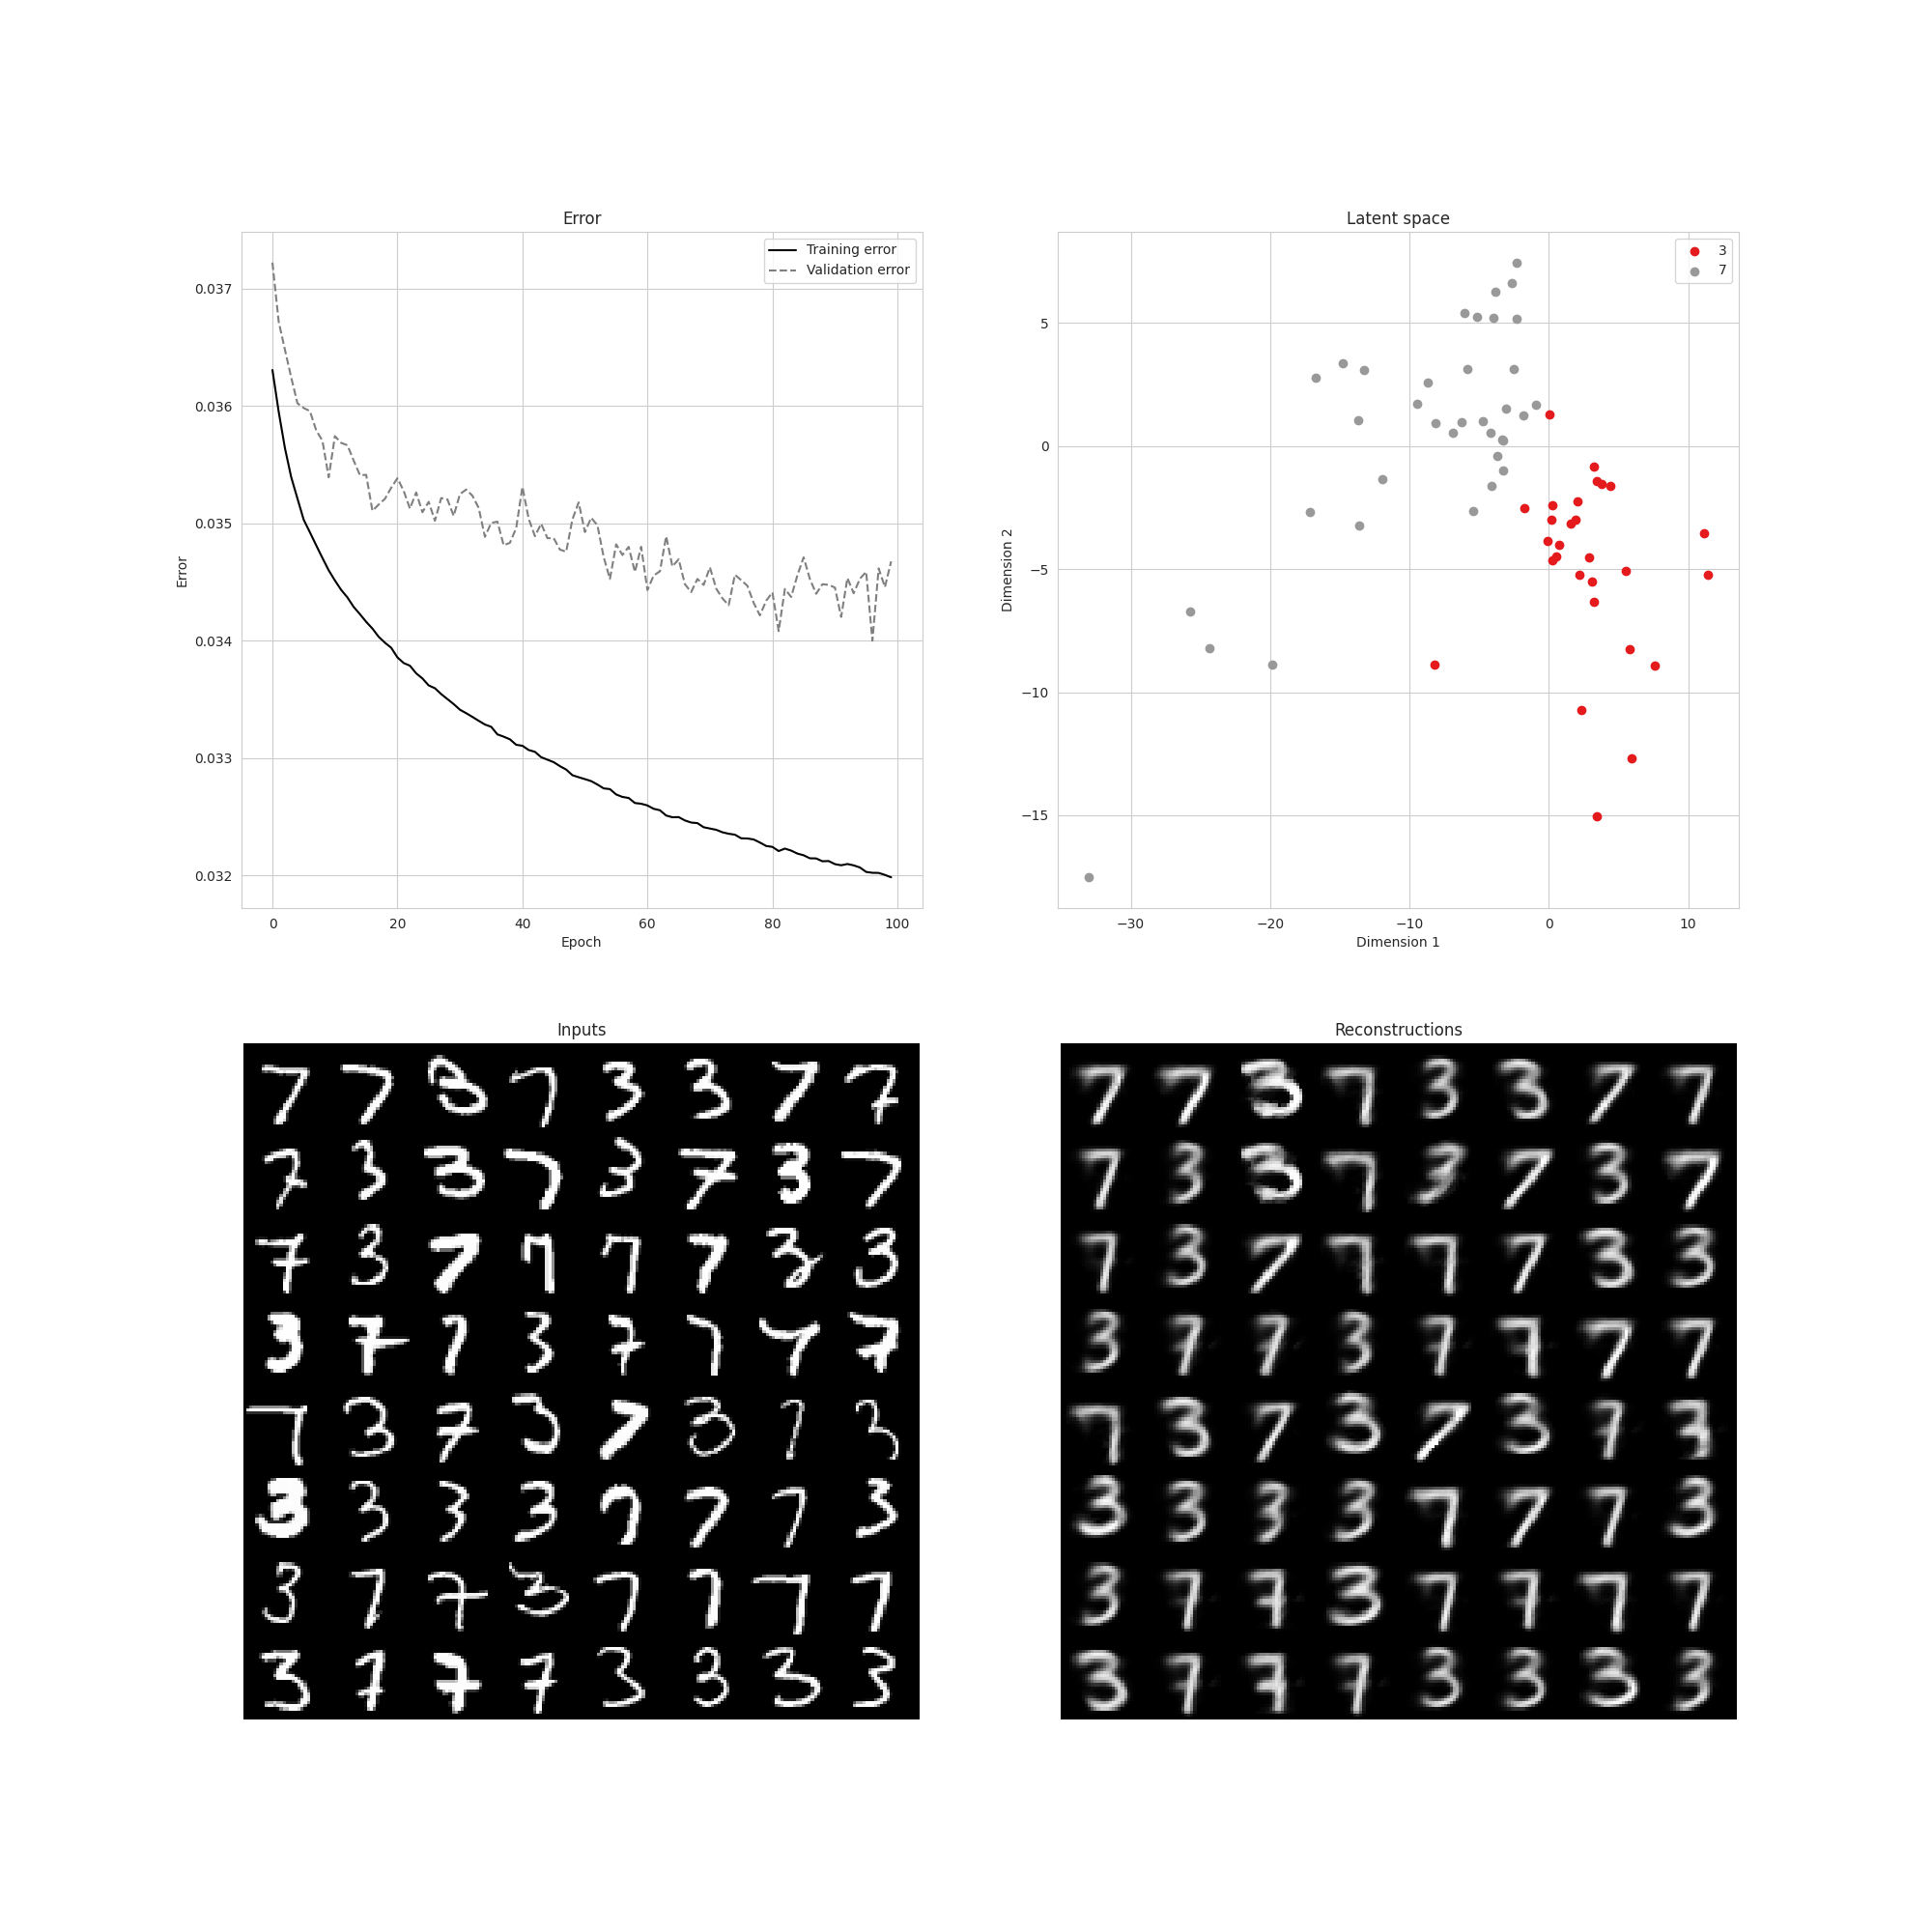

In [ ]:
# Number of epochs
num_epochs = 100

# Placeholders for loss tracking
train_loss = []
valid_loss = []

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError()

# Training loop
for epoch in range(num_epochs):
    batch_loss = []

    # Training step
    for x,y in train_dataset:
        with tf.GradientTape() as tape:
            outputs = net(x, training=True)
            loss = loss_function(x, outputs['x_hat'])

        gradients = tape.gradient(loss, net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))

        batch_loss.append(loss.numpy())

    train_loss.append(np.mean(batch_loss))

    # Validation step (no gradient calculation)
    for x,y in test_dataset.take(1):  # Just take one batch from the test set
        outputs = net(x, training=False)
        x_hat = outputs['x_hat']

        loss = loss_function(x, x_hat)
        valid_loss.append(loss.numpy())

    # Optional: live plotting or custom logging
    if epoch > 0:
        plot_autoencoder_stats_keras(
            x=x,
            x_hat=x_hat,
            z=outputs['z'].numpy(),  # If you want to visualize latent space, modify the call method to return `z` as well
            y=tf.argmax(y, axis=1).numpy(),  # Modify if you have labels and want to use them in plotting
            train_loss=train_loss,
            valid_loss=valid_loss,
            epoch=epoch,
            classes=classes,  # Modify if you want to visualize specific classes
            dimensionality_reduction_op=None  # Add if you want to apply dimensionality reduction
        )

### Tarea 1 - Analizando el Autoencoder (AE)
1. La implementación anterior de un AE es muy simple.
    - Experimenta con el número de capas e intenta con diferentes no linealidades para mejorar las reconstrucciones.
    - ¿Qué sucede con la red cuando cambiamos las no linealidades en la capa latente (por ejemplo, sigmoide)?
    - Intenta aumentar el número de clases de dígitos en el conjunto de entrenamiento y analiza los resultados.
    - Opcional: Prueba diferentes algoritmos de optimización como ADAM y RMSProp, y decide si deberías usar regularizadores.
       
2. Actualmente optimizamos con respecto al error cuadrático medio (MSE).
    - Encuentra otra función de error que pueda adaptarse mejor a este problema.
    - Evalúa si la función de similitud $d$ es una mejor opción y explica tus hallazgos.

3. Complejidad del cuello de botella.
    - Aumenta el número de unidades en la capa latente y entrena el modelo.
    - Visualiza utilizando [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) o [UMAP](https://umap-learn.readthedocs.io/en/latest/).

## Tarea 2 - Añadiendo Clasificación para Aprendizaje Semi-Supervisado

El entrenamiento anterior se ha realizado de manera no supervisada. Ahora supongamos que solo tenemos una fracción de los puntos de datos etiquetados de cada clase. Como sabemos, el aprendizaje semi-supervisado se puede utilizar combinando el aprendizaje no supervisado y supervisado. Ahora debes analizar si un AE entrenado en el ejercicio anterior puede ayudar a un clasificador.

1. Construye un clasificador simple donde:
    - Entrena en el conjunto de datos etiquetados y evalúa los resultados.
2. Construye un segundo clasificador y entrena en la salida latente $\mathbf{z}$ del AE.
3. Construye un tercer clasificador y entrena en las reconstrucciones del AE.
4. Evalúa los clasificadores entre sí e implementa un modelo que mejore la clasificación combinando la entrada, la salida latente y la reconstrucción.

A continuación, proporcionamos algún código de inicio para usar solo un subconjunto de los datos etiquetados.


In [ ]:
def uniform_stratified_sampler(labels, classes, n=None):
    """
    Stratified sampler that distributes labels uniformly by
    sampling at most n data points per class.
    """
    # Ensure labels are a NumPy array
    if isinstance(labels, tf.Tensor):
        labels = labels.numpy()

    indices = np.arange(len(labels))

    # Find indices for each class
    class_indices = []
    for cls in classes:
        cls_indices = indices[labels == cls]
        class_indices.append(cls_indices)

    # Shuffle each class's indices and sample `n` from each class
    sampled_indices = [np.random.choice(idx, size=min(len(idx), n), replace=False) for idx in class_indices]

    # Flatten the list of sampled indices and shuffle
    sampled_indices = np.hstack(sampled_indices)
    np.random.shuffle(sampled_indices)

    return sampled_indices

def extract_labels_and_indices(dataset):
    labels_list = []
    indices_list = []

    for i, (x, y) in enumerate(dataset):
        labels_list.append(y.numpy())
        indices_list.append(i)

    labels_array = np.concatenate(labels_list, axis=0)
    indices_array = np.array(indices_list)

    return labels_array, indices_array

# Example usage with a train_dataset
labels_per_class = 10
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Example for MNIST

# Assuming `train_dataset` is your tf.data.Dataset
labels, indices = extract_labels_and_indices(train_dataset)

# Apply stratified sampling
sampled_indices = uniform_stratified_sampler(np.argmax(labels,axis=1), classes, n=labels_per_class)

# Create a new dataset with sampled indices
sampled_data = [data for i, data in enumerate(train_dataset) if i in sampled_indices]
sampled_dataset = tf.data.Dataset.from_generator(lambda: sampled_data, output_signature=(
    tf.TensorSpec(shape=(784), dtype=tf.float32),  # Adjust shape and dtype as needed
    tf.TensorSpec(shape=(), dtype=tf.int64)
))

# Batch and shuffle the dataset
batch_size = 64
labelled_dataset = sampled_dataset.shuffle(buffer_size=len(sampled_indices)).batch(batch_size)

In [ ]:
# Assuming `labelled_dataset` and `unlabelled_dataset` are tf.data.Dataset objects
# Example: labelled_dataset = tf.data.Dataset.from_tensor_slices((labelled_data, labelled_labels)).batch(batch_size)
# Example: unlabelled_dataset = tf.data.Dataset.from_tensor_slices((unlabelled_data, unlabelled_labels)).batch(batch_size)

# Define your classifier or model (e.g., autoencoder)
# Assuming `autoencoder` is your model and `optimizer` is defined
from itertools import cycle

optimizer = tf.keras.optimizers.Adam()

num_epochs = 100

for epoch in range(num_epochs):
    # Create iterators for both datasets
    labelled_iter = iter(cycle(labelled_dataset))
    unlabelled_iter = iter(labelled_dataset) #Modify

    while True:
        try:
            # Get the next batch from the labelled dataset (cycling through it)
            x, y = next(labelled_iter)
        except StopIteration:
            # If we reach the end of the labelled dataset, reset the iterator
            labelled_iter = iter(cycle(labelled_dataset))
            x, y = next(labelled_iter)

        try:
            # Get the next batch from the unlabelled dataset
            u, _ = next(unlabelled_iter)
        except StopIteration:
            # If we reach the end of the unlabelled dataset, break the loop
            break

        with tf.GradientTape() as tape:
            # Forward pass: Send labelled data through the autoencoder
            outputs = autoencoder(x, training=True)

            ### Define your loss function ###
            # For example, Mean Squared Error between input and reconstructed output
            loss = tf.reduce_mean(tf.square(x - outputs))

        # Backward pass: Compute gradients and apply them
        gradients = tape.gradient(loss, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))

        # Optionally, print the loss every few steps
        print(f"Epoch {epoch + 1}: Loss = {loss.numpy()}")

    print(f"Epoch {epoch + 1} completed.")

print("Training complete!")
